# Nutrient analysis of global fisheries

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import arviz as az

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutrients data
ndata = pd.read_csv('https://raw.githubusercontent.com/mamacneil/FishNutrients_sandbox/main/data/all_nutrients_active.csv?token=AADMXITPFVMF2LLKVPIPF4TASVILA')
# Traits data
tdata = pd.read_csv('https://raw.githubusercontent.com/mamacneil/FishNutrients_sandbox/main/data/all_traits_active.csv?token=AADMXIVH54FBLNNNE53HRDDASZ4UK')


In [4]:
tdata.columns.values

array(['species', 'Genus', 'Family', 'Order', 'Class', 'spec_code',
       'DemersPelag', 'EnvTemp', 'environment', 'Feeding_path',
       'BodyShape', 'DepthRangeDeep', 'Lmax', 'trophic_level', 'K', 'tm'],
      dtype=object)

In [5]:
# Add traits information to nutritional dataframe
indx = match(ndata.spec_code.unique(),list(tdata.spec_code.values))
rindx = match(ndata.spec_code,list(ndata.spec_code.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus', 'DemersPelag','EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'Lmax','BodyShape', 'K', 'tm']

# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]
ndata.head()

,species,spec_code,nutrient,value,sample_size,variance,sample_form,prep_form,environment,Class,...,Genus,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,Lmax,BodyShape,K,tm
0,Merluccius_merluccius,30,Selenium,65.0000,NaN,10.0,muscle,wet,marine,Actinopterygii,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.13,4.80
1,Scomber_scombrus,118,Selenium,208.0000,NaN,26.0,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
2,Scomber_scombrus,118,Zinc,0.8090,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
3,Scomber_scombrus,118,Selenium,22.4000,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
4,Merluccius_gayi_gayi,324,Zinc,0.1787,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Merluccius,demersal,polar_deep,500.0,4.32,pelagic,87.0,fusiform,0.25,3.67


In [6]:
ndata.columns.values

array(['species', 'spec_code', 'nutrient', 'value', 'sample_size',
       'variance', 'sample_form', 'prep_form', 'environment', 'Class',
       'Order', 'Family', 'Genus', 'DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'Lmax',
       'BodyShape', 'K', 'tm'], dtype=object)

### Datasets

In [7]:
# List available nutrients
Nutrients =  ndata.nutrient.unique()
# Number of nutrients
nnut = len(Nutrients)
# Return sample sizes
pd.DataFrame({'Nutrient':Nutrients,'Sample size':[sum(ndata.nutrient.values==n) for n in Nutrients]})


,Nutrient,Sample size
0,Selenium,299
1,Zinc,556
2,Protein,1004
3,Omega_3,291
4,Calcium,562
5,Iron,587
6,Vitamin_A,259


## ======= Change nutrient here & likelihood in the model ========= #

In [8]:
i = 2
nut = Nutrients[i]
nut

'Protein'

In [9]:
nut = Nutrients[i]
print('Now modelling '+nut+'...')

Now modelling Protein...


In [10]:
tmpdata = ndata[ndata.nutrient==nut]

# Filter out zeros?
tmpdata = tmpdata[tmpdata.value!=0].copy()

# Response
Y = tmpdata.value.values
Ylog = np.log(Y)

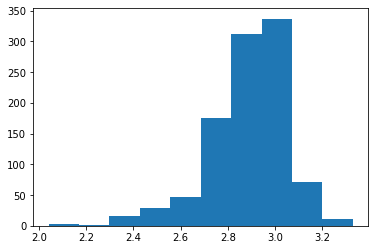

In [11]:
plt.hist(Ylog);

(array([95., 74., 39., 27., 22.,  6.,  6.,  6.,  2.,  3.]),
 array([0.  , 0.37, 0.74, 1.11, 1.48, 1.85, 2.22, 2.59, 2.96, 3.33, 3.7 ]),
 <BarContainer object of 10 artists>)

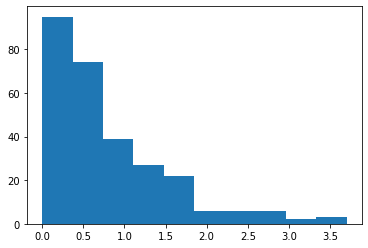

In [12]:
plt.hist(tmpdata.variance)

In [13]:
np.isnan(tmpdata.variance).mean()

0.7211155378486056

In [14]:
np.isnan(tmpdata.sample_size).mean()

0.48904382470119523

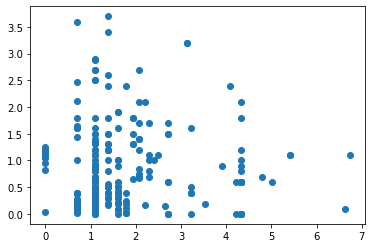

In [15]:
plt.scatter(np.log(tmpdata.sample_size),tmpdata.variance)

In [21]:
tmpdata.columns

Index(['species', 'spec_code', 'nutrient', 'value', 'sample_size', 'variance',
       'sample_form', 'prep_form', 'environment', 'Class', 'Order', 'Family',
       'Genus', 'DemersPelag', 'EnvTemp', 'DepthRangeDeep', 'trophic_level',
       'Feeding_path', 'Lmax', 'BodyShape', 'K', 'tm'],
      dtype='object')

In [37]:
# Index for orders
Class,Icl = subindexall(tmpdata["Class"], tmpdata["Order"])
ncl = len(Class)

Order,Ior = subindexall(tmpdata["Order"], tmpdata["Family"])
nor = len(Order)

Family,Ifa = subindexall(tmpdata["Family"], tmpdata["Genus"])
nga = len(Family)

Ige,Genus = pd.factorize(tmpdata["Genus"], sort=True)
ngen = len(Genus)

# Index for species
spxs = list(tmpdata['species'].values)
sindx = np.array([spxs.index(s) for s in np.unique(spxs)])

# Species-level covariates
Habitat,Ih = subindexall(tmpdata['DemersPelag'].values, tmpdata['species'].values)
nhabs = len(Habitat)
Climate,Ic = subindexall(tmpdata['EnvTemp'].values, tmpdata['species'].values)
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)[sindx]
TL = tmpdata['trophic_level'].values[sindx]
FeedingPath, Ifp = indexall(tmpdata['Feeding_path'].values[sindx])
nfp = len(FeedPath)
LMax = np.log(tmpdata['Lmax'].values)[sindx]
BodyShape,Ib = subindexall(tmpdata['BodyShape'].values, tmpdata['species'].values)
nbod = len(Body)
K = tmpdata['K'].values[sindx]
tm = np.log(tmpdata['tm'].values)[sindx]

# Nussiance parameters
Form,If = indexall(tmpdata['sample_form'].values)
nform = len(Form)
Prep,Ip = indexall(tmpdata['prep_form'].values)
nprep = len(Prep)

# Measurement error and replace zeros
obs_var = tmpdata.variance.replace(0, np.nan)
obs_var = obs_var[np.isfinite(obs_var)].values

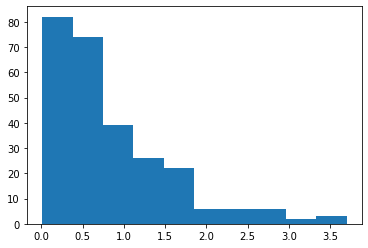

In [23]:
plt.hist(obs_var);

In [24]:
min(obs_var)

0.01

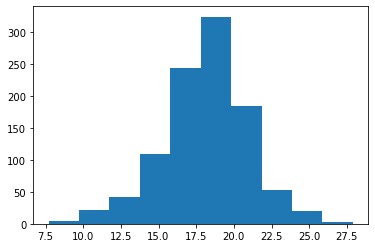

In [25]:
plt.hist(Y);

## Phylogeny



In [26]:
# Phylogentic distance matrix
pdata = pd.read_csv('mean_phy_dist.csv')
pdata.rename(columns={'Unnamed: 0':'spp'}, inplace=True)

# Average phylogentic relatedness value
meanp = np.mean(pdata,axis=1).mean()
# Store key for species locations in matrix
pkey = pdata.spp.values
# Drop species names column
pdata = pdata.drop('spp',axis=1)
# Add last row of average and turn into matrix
pdata = np.vstack([pdata.values,[meanp]*len(pdata.values[0])])
pdata = np.hstack((pdata, np.ones((pdata.shape[0], 1), dtype=pdata.dtype)*meanp))
# Set last diagonal value to -999
pdata[pdata.shape[0]-1,pdata.shape[0]-1] = -999
# Add missing species location
pkey = np.append(pkey,'Missing')

In [27]:
# Unique species in nutrients data
NutSpecies,Isp = indexall(tmpdata.species.values)
nspp = len(NutSpecies)
# Grab phylogentic matrix index for species in data
pindx = match(NutSpecies,list(pkey))
# Assign missing index for missing species
pindx[pindx==None] = pdata.shape[0]-1
pindx = pindx.astype(int)

In [28]:
len(Ih)

455

In [29]:
# Grab matching phylogentic matrix
Pmat = np.array([p[pindx] for p in pdata[pindx]])

In [30]:
# Replace missing values with average, plus some error
Pmat[Pmat==-999] = np.mean(Pmat[Pmat!=0][Pmat[Pmat!=0]!=-999])+np.random.normal(0,0.1,len(Pmat[Pmat==-999]))
# Scale correlations
Pmat = Pmat/max(Pmat.flatten())
# Constrain max correlation to 0.9
#Pmat[Pmat>0.9] = 0.9
# Diagonal
np.fill_diagonal(Pmat,0)

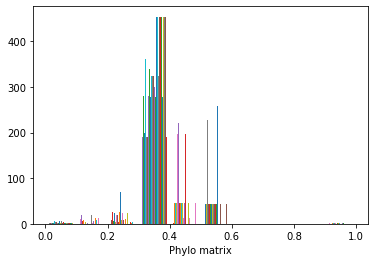

In [31]:
plt.hist(Pmat)
plt.xlabel('Phylo matrix');

## Specify Bayesian model

In [32]:
# Custom function 
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.b3 = b3
        self.b4 = b4
        self.b5 = b5
        self.b6 = b6
        self.b7 = b7
        self.b8 = b8
        self.b9 = b9

    def __call__(self, X):
        """Where do the covariates come from?"""
        return self.b0+self.b1+self.b2+self.b3*MaxDepth+self.b4*TL+self.b5+self.b6*LMax+self.b7+self.b8*K+self.b9*tm

In [42]:
len(Ib)

455

In [45]:
coords = {'Class':Class,
          'Order':Order,
          'Family':Family,
          'Genus':Genus,
    'Habitat': Habitat,
    'Climate': Climate,
    'BodyShape': BodyShape,
    'FeedingPath':FeedingPath,
    'Form': Form,
    'Prep': Prep,
}

Nsd = 1

with pm.Model(coords=coords) as Model_1:
    ## Species level parameters
    # Intercept
    β0 = pm.Normal('Intercept', 0, 1)
    # Habitat type
    β1 = pm.Normal('Habitat_x', 0, Nsd, dims='Habitat')
    # Climate
    β2 = pm.Normal('Climate_x', 0, Nsd, dims='Climate')
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, Nsd)
    # Total Length
    β4 = pm.Normal('TL', 0, Nsd)
    # Pelagic/demersal
    β5 = pm.Normal('FeedingPath_x', 0, Nsd, dims='FeedingPath')
    # Maximum length
    β6 = pm.Normal('LMax', 0, Nsd)
    # Body form
    β7 = pm.Normal('BodyShape_x', 0, Nsd, dims='BodyShape')
    # Growth parameter
    β8 = pm.Normal('K', 0, Nsd)
    # Age at maturity
    β9 = pm.Normal('tm', 0, Nsd)
    
    # Linear model for each species
    mu = LinearMean(β0,β1[Ih],β2[Ic],β3,β4,β5[Ifp],β6,β7[Ib],β8,β9)
    
    # half_normal(1, 0.25) is too strong
    etasq = pm.Exponential("etasq", .25)
    rhosq = pm.Normal("rhosq", 3, .25)
    #etasq = pm.Normal("etasq", 1.0, 0.25)
    
    # specify the covariance function:
    cov = etasq * pm.gp.cov.Exponential(input_dim=nspp, ls=rhosq)
    
    
    gp = pm.gp.Latent(mean_func=mu, cov_func=cov)
    # Species-level intercepts
    μ0 = gp.prior("μ0", X=Pmat)
    
    ## Observation level nussiance parameters
    # Form of sample
    β10 = pm.Normal('Form_x', 0, Nsd, dims='Form')
    # Form of prepartion
    β11 = pm.Normal('Prep_x', 0, Nsd, dims='Prep')
    # Observation model
    μ_ = μ0[Isp]+β10[If]+β11[Ip]
    
    if nut in ['Protein']:
        μ = μ_
        σα = pm.Gamma('obs_alpha', 10, 10)
        σβ = pm.Gamma('obs_beta', 10, 10)
        #σ_ = pm.Gamma('Sigma_est', σα, σβ, observed=obs_var)
        ν = pm.Uniform('nu', 0, 20)
        σ = pm.Gamma('Sigma', σα, σβ)
        Yi = pm.StudentT('Yi', ν, μ, σ, observed=Y)
        ExMu = pm.Deterministic('ExMu', μ_)
    elif nut in ['Omega_3']:
        μ = μ_
        σα = pm.Gamma('obs_alpha', 10, 10)
        σβ = pm.Gamma('obs_beta', 10, 10)
        σ = pm.Gamma('Sigma', σα, σβ, observed=obs_var)
        ν = pm.Uniform('nu', 0, 20)
        Yi = pm.StudentT('Yi', ν, μ, σ, observed=Ylog)
        ExMu = pm.Deterministic('ExMu', tt.exp(μ_))
    elif nut in ['Zinc','Iron']:
        μ = pm.math.exp(μ_)
        σ = pm.Uniform('Sigma', 0, 10)
        Yi = pm.Gamma('Yi', alpha=σ, beta=σ/μ, observed=Y)
    else:
        μ = μ_
        σ = pm.Exponential('Sigma', 1)
        Yi = pm.Normal('Yi', μ, σ, observed=Y)
        ExMu = pm.Deterministic('ExMu', μ_)
    
    

# Prior predictive distribution

In [46]:
with Model_1:
    prior = pm.sample_prior_predictive(700)
    Model_1_priorp = az.from_pymc3(prior=prior)

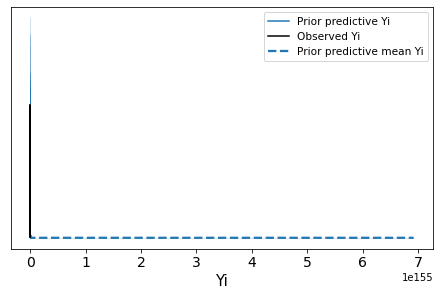

In [47]:
az.plot_ppc(Model_1_priorp, group="prior").figure.savefig(nut+'_PriorPC.jpg')


# Inference

In [49]:
with Model_1:
    trace = pm.sample(1000)

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, nu, obs_beta, obs_alpha, Prep_x, Form_x, μ0_rotated_, rhosq, etasq, tm, K, BodyShape_x, LMax, FeedingPath_x, TL, MaxDepth, Climate_x, Habitat_x, Intercept]


ValueError: Not enough samples to build a trace.

In [ ]:
pm.plot_trace(trace).ravel()[0].figure.savefig(nut+'_Trace.jpg')

In [ ]:
pm.summary(trace).to_csv(nut+'_Summary.csv',index=False)

In [ ]:
pm.summary(trace)

In [ ]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
out.to_csv(nut+'_results.csv')

In [ ]:
out.head()

# Posterior predictive

In [ ]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=Model_1)

In [ ]:
idata_checks = az.from_pymc3(
        model=Model_1,
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive)

In [ ]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="Yi", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

In [ ]:
plot_ppc_loopit(idata_checks,nut+'_checks').ravel()[0].figure.savefig(nut+'_LooPit.jpg')

In [ ]:
# Grab observation-level predictions
Ypred_mu = np.quantile(trace['ExMu'].T,0.5,axis=1)
Ypred_l90 = np.quantile(trace['ExMu'].T,0.05,axis=1)
Ypred_u90 = np.quantile(trace['ExMu'].T,0.95,axis=1)

# Proportion of observations captured
'Captured '+str(np.round(np.mean(np.array([ylo<y<yup for y,ylo,yup in zip(Y,Ypred_l90,Ypred_u90)]))*100,1))+'% of '+nut+' observations'

In [ ]:
plt.plot((Y,Y),(Ypred_l90,Ypred_u90),c='b')
plt.scatter(Y,Ypred_mu,s=70)
plt.scatter(Y,Y,s=70,c='red');

In [ ]:
plt.hist(Y,bins=50)
plt.hist(Ypred_mu,bins=50);